<a href="https://colab.research.google.com/github/Navya78sd/House-Price-Prediction/blob/main/Robot_Path_finding_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running 50 experiments for each heuristic...
  ... starting run 10/50
  ... starting run 20/50
  ... starting run 30/50
  ... starting run 40/50
  ... starting run 50/50

--- Average Results ---
Heuristic    | Avg. Path Length   | Avg. Nodes Expanded  | Avg. Time (ms) 
----------------------------------------------------------------------
Manhattan    | 15.94              | 22.90                | 0.6589         
Euclidean    | 15.58              | 30.74                | 0.7676         
Diagonal     | 15.54              | 73.66                | 2.6099         


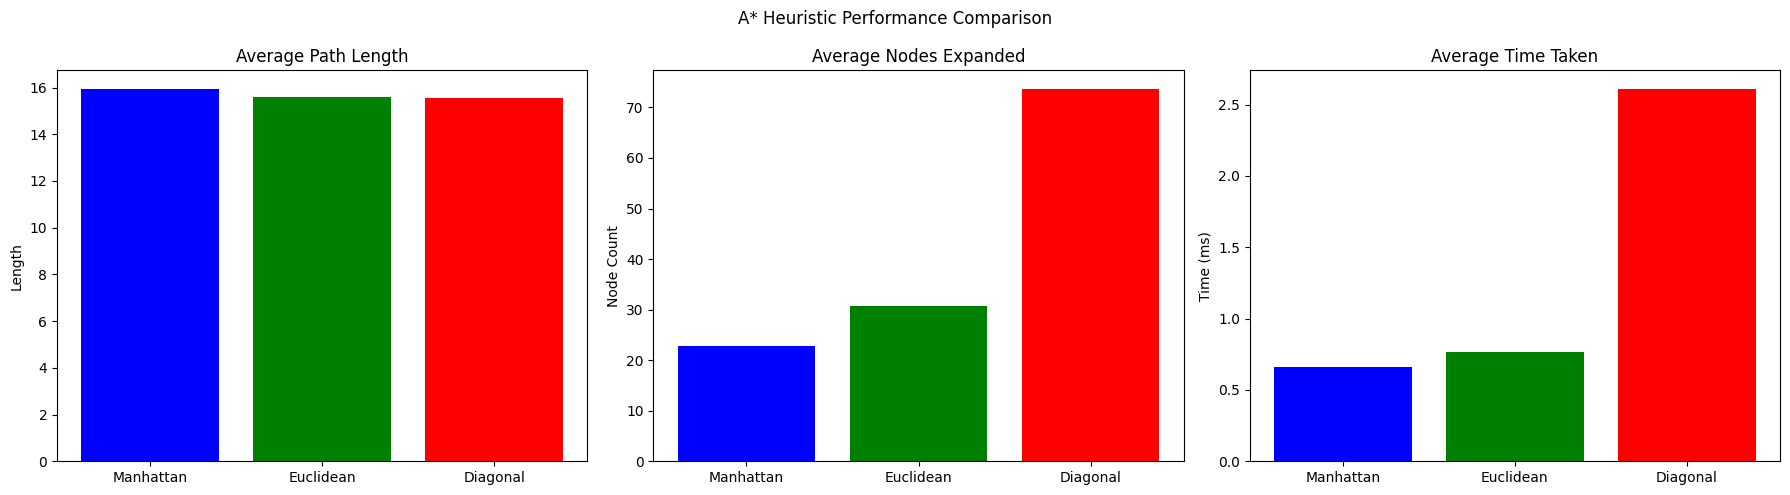

In [1]:
import heapq
import random
import time
import math
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Grid and Node Setup ---

class Node:
    """A node in the search graph."""
    def __init__(self, position, parent=None):
        self.position = position  # (row, col)
        self.parent = parent

        self.g = 0  # Cost from start to current node
        self.h = 0  # Heuristic cost from current node to goal
        self.f = 0  # Total cost: f = g + h

    def __eq__(self, other):
        return self.position == other.position

    def __lt__(self, other):
        return self.f < other.f

    def __hash__(self):
        return hash(self.position)

def create_grid(rows, cols, obstacle_rate):
    """
    Creates a grid with random obstacles, a random start, and a random goal.

    Returns (grid, start_pos, goal_pos)
    """
    grid = np.zeros((rows, cols))

    # 1. Place obstacles
    num_obstacles = int(rows * cols * obstacle_rate)
    for _ in range(num_obstacles):
        row, col = random.randint(0, rows - 1), random.randint(0, cols - 1)
        grid[row][col] = 1  # 1 represents an obstacle

    # 2. Find random start position (must be a free cell)
    while True:
        start_pos = (random.randint(0, rows - 1), random.randint(0, cols - 1))
        if grid[start_pos[0]][start_pos[1]] == 0:
            break

    # 3. Find random goal position (must be free and not the start)
    while True:
        goal_pos = (random.randint(0, rows - 1), random.randint(0, cols - 1))
        if grid[goal_pos[0]][goal_pos[1]] == 0 and goal_pos != start_pos:
            break

    return grid, start_pos, goal_pos

# --- 2. Heuristics ---

def manhattan_distance(pos1, pos2):
    """Manhattan distance heuristic (L1 norm)."""
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

def euclidean_distance(pos1, pos2):
    """Euclidean distance heuristic (L2 norm)."""
    return math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def diagonal_distance(pos1, pos2):
    """
    Diagonal (Chebyshev) distance heuristic (L-infinity norm).
    Assumes 8-way movement (cost 1 for cardinal, 1 for diagonal).
    """
    return max(abs(pos1[0] - pos2[0]), abs(pos1[1] - pos2[1]))

# --- 3. A* Search Algorithm ---

def a_star_search(grid, start_pos, goal_pos, heuristic_func):
    """
    Performs A* search.
    Returns (path, nodes_expanded, time_taken)
    """
    start_time = time.perf_counter()

    start_node = Node(start_pos)
    goal_node = Node(goal_pos)

    open_list = []  # Priority queue
    closed_list = set() # Set of visited positions

    heapq.heappush(open_list, start_node)
    nodes_expanded = 0

    while open_list:
        # 1. Get the node with the lowest f-score
        current_node = heapq.heappop(open_list)
        nodes_expanded += 1

        if current_node.position in closed_list:
            continue

        closed_list.add(current_node.position)

        # 2. Check for goal
        if current_node == goal_node:
            path = []
            temp = current_node
            while temp:
                path.append(temp.position)
                temp = temp.parent

            time_taken = time.perf_counter() - start_time
            return path[::-1], nodes_expanded, time_taken  # Return reversed path

        # 3. Get neighbors (8-way movement)
        (r, c) = current_node.position
        for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]:
            neighbor_pos = (r + dr, c + dc)

            # Check boundaries
            if not (0 <= neighbor_pos[0] < grid.shape[0] and 0 <= neighbor_pos[1] < grid.shape[1]):
                continue

            # Check obstacles
            if grid[neighbor_pos[0]][neighbor_pos[1]] == 1:
                continue

            # Check if already processed
            if neighbor_pos in closed_list:
                continue

            # 4. Calculate costs
            new_g = current_node.g + 1

            neighbor_node = Node(neighbor_pos, current_node)
            neighbor_node.g = new_g
            neighbor_node.h = heuristic_func(neighbor_pos, goal_pos)
            neighbor_node.f = neighbor_node.g + neighbor_node.h

            # 5. Add to open list
            found_better = False
            for node in open_list:
                if node == neighbor_node and node.g < new_g:
                    found_better = True
                    break

            if not found_better:
                heapq.heappush(open_list, neighbor_node)

    # No path found
    time_taken = time.perf_counter() - start_time
    return None, nodes_expanded, time_taken

# --- 4. Experimental Setup ---

def run_experiments(num_runs, grid_size, obstacle_rate):
    """
    Runs the A* search with all heuristics multiple times
    and returns aggregated results.
    """
    heuristics = {
        "Manhattan": manhattan_distance,
        "Euclidean": euclidean_distance,
        "Diagonal": diagonal_distance
    }

    # Store results: { 'HeuristicName': { 'metric': [val1, val2, ...] } }
    results = {name: {'path_length': [], 'nodes_expanded': [], 'time_taken': []}
               for name in heuristics}

    print(f"Running {num_runs} experiments for each heuristic...")

    for i in range(num_runs):
        if (i+1) % 10 == 0:
            print(f"  ... starting run {i+1}/{num_runs}")

        grid, start, goal = create_grid(grid_size, grid_size, obstacle_rate)

        for name, func in heuristics.items():
            path, nodes, time_val = a_star_search(grid, start, goal, func)

            if path:
                results[name]['path_length'].append(len(path))
            else:
                results[name]['path_length'].append(np.nan) # Path not found

            results[name]['nodes_expanded'].append(nodes)
            results[name]['time_taken'].append(time_val)

    # Calculate averages
    avg_results = {}
    for name, metrics in results.items():
        avg_results[name] = {
            'Avg. Path Length': np.nanmean(metrics['path_length']),
            'Avg. Nodes Expanded': np.mean(metrics['nodes_expanded']),
            'Avg. Time (ms)': np.mean(metrics['time_taken']) * 1000
        }

    return avg_results

def plot_results(avg_results):
    """Generates and shows bar charts for performance comparison."""
    # This is the line that was fixed.
    labels = list(avg_results.keys())

    metrics = {
        'Avg. Path Length': [res['Avg. Path Length'] for res in avg_results.values()],
        'Avg. Nodes Expanded': [res['Avg. Nodes Expanded'] for res in avg_results.values()],
        'Avg. Time (ms)': [res['Avg. Time (ms)'] for res in avg_results.values()]
    }

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('A* Heuristic Performance Comparison')

    # Plot 1: Avg. Path Length
    axes[0].bar(labels, metrics['Avg. Path Length'], color=['blue', 'green', 'red'])
    axes[0].set_title('Average Path Length')
    axes[0].set_ylabel('Length')

    # Plot 2: Avg. Nodes Expanded
    axes[1].bar(labels, metrics['Avg. Nodes Expanded'], color=['blue', 'green', 'red'])
    axes[1].set_title('Average Nodes Expanded')
    axes[1].set_ylabel('Node Count')

    # Plot 3: Avg. Time
    axes[2].bar(labels, metrics['Avg. Time (ms)'], color=['blue', 'green', 'red'])
    axes[2].set_title('Average Time Taken')
    axes[2].set_ylabel('Time (ms)')

    plt.tight_layout()
    plt.show() # This command displays the plot in Colab

# --- 5. Main Execution ---
if __name__ == "__main__":
    # --- Parameters ---
    NUM_RUNS = 50       # Number of random grids to test
    GRID_SIZE = 30      # Grid will be 30x30
    OBSTACLE_RATE = 0.2 # 20% of cells will be obstacles

    # --- Run ---
    avg_data = run_experiments(NUM_RUNS, GRID_SIZE, OBSTACLE_RATE)

    # --- Print Results Table ---
    print("\n--- Average Results ---")
    print(f"{'Heuristic':<12} | {'Avg. Path Length':<18} | {'Avg. Nodes Expanded':<20} | {'Avg. Time (ms)':<15}")
    print("-" * 70)
    for name, metrics in avg_data.items():
        print(f"{name:<12} | {metrics['Avg. Path Length']:<18.2f} | {metrics['Avg. Nodes Expanded']:<20.2f} | {metrics['Avg. Time (ms)']:<15.4f}")

    # --- Plot Results ---
    plot_results(avg_data)
